In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
#Load The Libraries

import matplotlib.pyplot as plt 
import cv2 as cv

from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam,RMSprop 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle

%matplotlib inline

Using TensorFlow backend.


In [3]:
train=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train = train.iloc[np.random.permutation(len(train))]
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
32845,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39229,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39826,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24120,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28167,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape

(42000, 785)

In [5]:
#Preparing Training and Validation data

sample_size = train.shape[0] # Training set size
validation_size = int(train.shape[0]*0.1) # Validation set size 

# train_x and train_y
train_x = np.asarray(train.iloc[:sample_size-validation_size,1:]).reshape([sample_size-validation_size,28,28,1]) # taking all columns expect column 0
train_y = np.asarray(train.iloc[:sample_size-validation_size,0]).reshape([sample_size-validation_size,1]) # taking column 0

# val_x and val_y
val_x = np.asarray(train.iloc[sample_size-validation_size:,1:]).reshape([validation_size,28,28,1])
val_y = np.asarray(train.iloc[sample_size-validation_size:,0]).reshape([validation_size,1])

In [6]:
train_x.shape,train_y.shape

((37800, 28, 28, 1), (37800, 1))

In [7]:
#Loading test.csv

test = pd.read_csv("../input/digit-recognizer/test.csv")
test_x = np.asarray(test.iloc[:,:]).reshape([-1,28,28,1])

Normalize Pixel Data¶
Each pixel values lies between [0,255].

In [8]:
train_x = train_x/255
val_x = val_x/255
test_x = test_x/255

 Frequency plot for training set¶

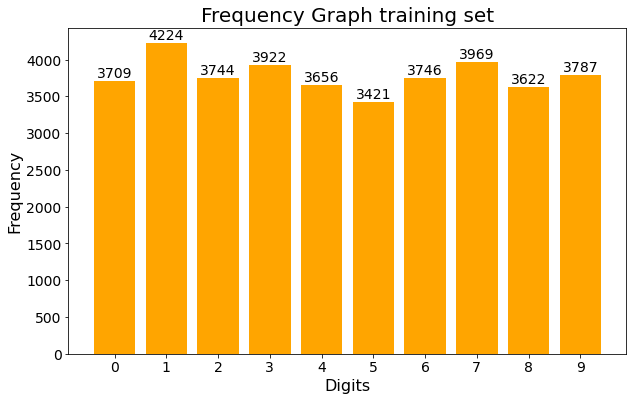

In [9]:
counts = train.iloc[:sample_size-validation_size,:].groupby('label')['label'].count()
# df_train.head(2)
# counts
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+50,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph training set",fontsize=20)
plt.show()



Frequency plot for validation set

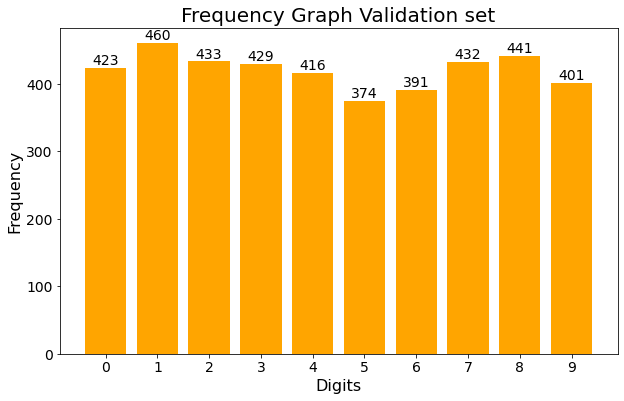

In [10]:
counts = train.iloc[sample_size-validation_size:,:].groupby('label')['label'].count()
# df_train.head(2)
# counts
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8,color="orange")
for i in counts.index:
    plt.text(i,counts.values[i]+5,str(counts.values[i]),horizontalalignment='center',fontsize=14)

plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title("Frequency Graph Validation set",fontsize=20)
plt.show()

Visualizing the digits by plotting Images¶

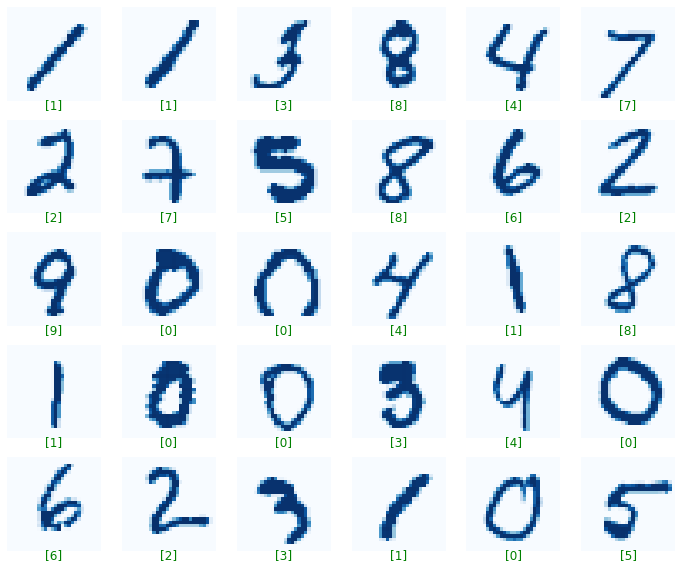

In [11]:
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train_x[i].reshape([28,28]),cmap="Blues") 
    plt.axis("off")
    plt.title(str(train_y[i]), y=-0.15,color="green")


Buliding Model
Model Using Keras¶

There are two different ways of defining the Model in Keras:

    Sequential Model
    Function API

Functional API is used to build a more complicated Model such as for multi-output Models, directed acyclic graphs, or models with shared layers. I am using the Sequential Model in this notebook to keep things simple.
In Sequential Model, you can add each layer sequentially.

Description of Model:

    => 2 Convolutional Blocks

        Each block consists of 2 Conv2D layers with LeakyRelU activation layers. Then a MaxPool2D layer and finally a Dropout Layer.

    => Then Dense Layers and Outpu layer after Flatten layer
    => MaxPool2D layer is used to reduce the size of image. Pool size (2,2) means reducing the image from (28,28) to (14,14). Reducing the features.
    => Dropout layer drops the few activation nodes while training which acts as regularization. Do let the model to over-fit
    => Output layer has 10 nodes with sigmoid activation.


In [12]:
model = models.Sequential()

In [13]:
model.add(Conv2D(32,3, padding  ="same",input_shape=(28,28,1)))
model.add(LeakyReLU())
model.add(Conv2D(32,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation="sigmoid"))

Compiling Model

Model compilation required the selection of optimizer and loss function. Let me discuss a few important things to avoid confusion.

Optimizers: Keras provides several optimizers that can be used by importing the optimizers and passing in compile function.

    SGD (Stochastic gradient descent optimizer)
    RMSprop
    Adam
    Adamax

There are several more check it out here.

One of the important things is the selection of the learning rate. If the learning rate is too high, the loss may not converge, and if it is too low, the training will be slow. So it is important to select the reasonably fair value of learning rate. One of the good value to start with is 0.001. If it doesn't work, then other higher or lower values can be tried. The rest of the parameters generally works well and need not be defined. The default value works most of the time. Here, I am using Adam optimizer, but RMSprop can also be used.

Loss Functions: Keras provides all of the well-known loss functions which work well for most of the time. But if you need to define a custom loss function, you can. Defining a custom function is out of the scope of this notebook. Let's understand the loss function for the classification tasks. 

In [14]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       


Training¶

model.fit() is used to train the model. It takes training data, batch_size, no of epochs, validation data. There are several more parameter, you can check the documentaion here. I am taking the epochs = 20 and batch size = 256. It will return the history of traning which later can be used to analyse the performance.


In [15]:
epochs = 20
batch_size = 256
history_1 = model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,validation_data=[val_x,val_y])

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 79s 2ms/step - loss: 0.4342 - accuracy: 0.8638 - val_loss: 0.0904 - val_accuracy: 0.9707
Epoch 2/20
37800/37800 [==============================] - 77s 2ms/step - loss: 0.0908 - accuracy: 0.9726 - val_loss: 0.0566 - val_accuracy: 0.9831
Epoch 3/20
37800/37800 [==============================] - 78s 2ms/step - loss: 0.0619 - accuracy: 0.9812 - val_loss: 0.0436 - val_accuracy: 0.9871
Epoch 4/20
37800/37800 [==============================] - 78s 2ms/step - loss: 0.0452 - accuracy: 0.9855 - val_loss: 0.0407 - val_accuracy: 0.9871
Epoch 5/20
37800/37800 [==============================] - 78s 2ms/step - loss: 0.0389 - accuracy: 0.9881 - val_loss: 0.0435 - val_accuracy: 0.9855
Epoch 6/20
37800/37800 [==============================] - 79s 2ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.0354 - val_accuracy: 0.9893
Epoch 7/20
37800/37800 [==============================] - 77s 2ms/ste


Training Performance.

Let's see how the training goes. Ploting the accuracy and loss of both training and validation set with each epochs. In the accuracy graphs there is clearly a difference in validation and training set. Model is more accurate on training set. It seems that model is litle bit overfit. So can we do better?




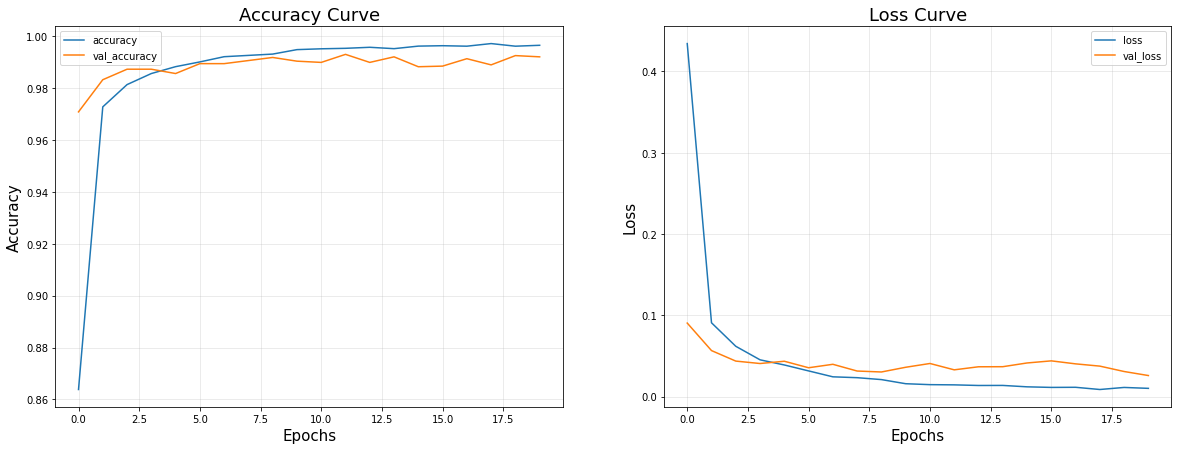

In [16]:
# Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(history_1.epoch,history_1.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch,history_1.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch,history_1.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch,history_1.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


In [17]:
#Confusion Matrix

val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1
        
confusion_matrix,error,(error*100)/val_p.shape[0],100-(error*100)/val_p.shape[0],val_p.shape[0]

print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])

Confusion Matrix: 

 [[419.   0.   1.   0.   0.   0.   3.   0.   0.   0.]
 [  0. 455.   0.   1.   1.   0.   0.   1.   1.   1.]
 [  0.   0. 432.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   1. 424.   0.   2.   0.   0.   2.   0.]
 [  0.   0.   1.   0. 413.   0.   0.   0.   0.   2.]
 [  0.   0.   0.   1.   0. 372.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 391.   0.   0.   0.]
 [  0.   2.   1.   0.   0.   1.   0. 425.   2.   1.]
 [  0.   1.   0.   0.   0.   1.   0.   0. 439.   0.]
 [  1.   0.   0.   0.   0.   0.   1.   2.   1. 396.]]

Errors in validation set:  34

Error Persentage :  0.8095238095238095

Accuracy :  99.19047619047619

Validation set Shape : 4200


Imporving Result by Image Augmentation¶

A deep network requires extensive data to achieve decent performance. To build a good classifier with small training data, image augmentation can solve the problem to a greater extend. Image augmentation generates images by different ways of processing, such as random shift, rotation, flips, etc.
Here I am using the ImageDataGenerator() function of keras for Image augmentation.

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

In [19]:
#Learning rate

lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.00001)

In [20]:
#Further Traning

epochs = 20
history_2 = model.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),steps_per_epoch=int(train_x.shape[0]/batch_size)+1,epochs=epochs,validation_data=[val_x,val_y],callbacks=[lrr])

Epoch 1/20
148/148 [==============================] - 83s 562ms/step - loss: 0.1258 - accuracy: 0.9639 - val_loss: 0.0243 - val_accuracy: 0.9917
Epoch 2/20
148/148 [==============================] - 82s 555ms/step - loss: 0.0658 - accuracy: 0.9792 - val_loss: 0.0217 - val_accuracy: 0.9929
Epoch 3/20
148/148 [==============================] - 81s 548ms/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.0235 - val_accuracy: 0.9926
Epoch 4/20
148/148 [==============================] - 82s 553ms/step - loss: 0.0472 - accuracy: 0.9851 - val_loss: 0.0222 - val_accuracy: 0.9926

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
148/148 [==============================] - 82s 556ms/step - loss: 0.0373 - accuracy: 0.9886 - val_loss: 0.0229 - val_accuracy: 0.9931
Epoch 6/20
148/148 [==============================] - 82s 557ms/step - loss: 0.0345 - accuracy: 0.9900 - val_loss: 0.0165 - val_accuracy: 0.9950
Epoch 7/20
148/148 [=============================

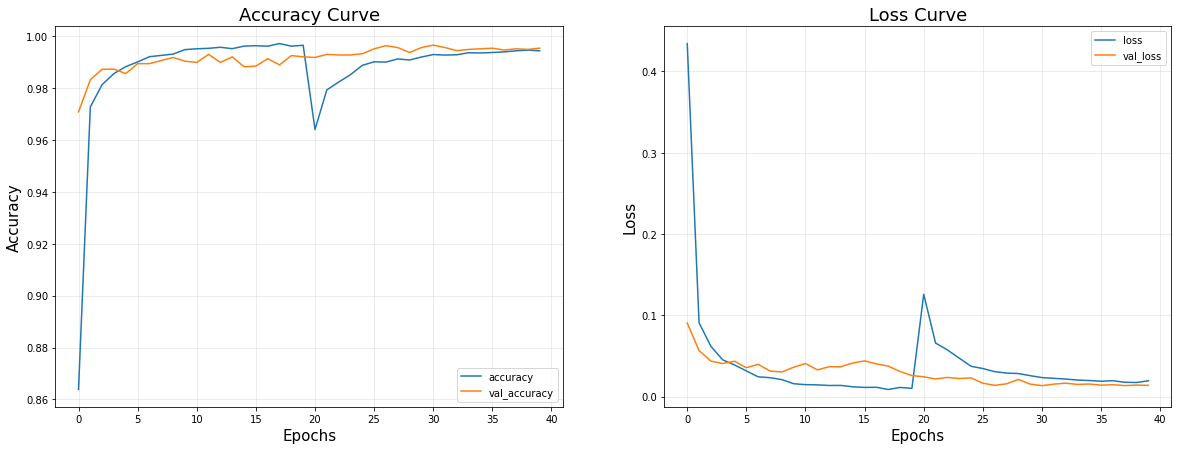

In [21]:
#Training Performance.**

f = plt.figure(figsize=(20,7))
f.add_subplot(121)

#Adding Subplot 1 (For Accuracy)
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['accuracy']+history_2.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_accuracy']+history_2.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['loss']+history_2.history['loss'],label="loss") # Loss curve for training set
plt.plot(history_1.epoch+list(np.asarray(history_2.epoch) + len(history_1.epoch)),history_1.history['val_loss']+history_2.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()




In [22]:
#Confusion Matrix

val_p = np.argmax(model.predict(val_x),axis =1)

error = 0
confusion_matrix = np.zeros([10,10])
for i in range(val_x.shape[0]):
    confusion_matrix[val_y[i],val_p[i]] += 1
    if val_y[i]!=val_p[i]:
        error +=1
        
confusion_matrix,error,(error*100)/val_p.shape[0],100-(error*100)/val_p.shape[0],val_p.shape[0]

print("Confusion Matrix: \n\n" ,confusion_matrix)
print("\nErrors in validation set: " ,error)
print("\nError Persentage : " ,(error*100)/val_p.shape[0])
print("\nAccuracy : " ,100-(error*100)/val_p.shape[0])
print("\nValidation set Shape :",val_p.shape[0])


Confusion Matrix: 

 [[421.   0.   0.   0.   0.   0.   2.   0.   0.   0.]
 [  0. 459.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  1.   0. 432.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1. 424.   0.   1.   0.   0.   3.   0.]
 [  0.   0.   0.   0. 411.   0.   0.   0.   0.   5.]
 [  0.   0.   0.   3.   0. 371.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 391.   0.   0.   0.]
 [  0.   2.   0.   0.   0.   0.   0. 430.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 441.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0. 400.]]

Errors in validation set:  20

Error Persentage :  0.47619047619047616

Accuracy :  99.52380952380952

Validation set Shape : 4200


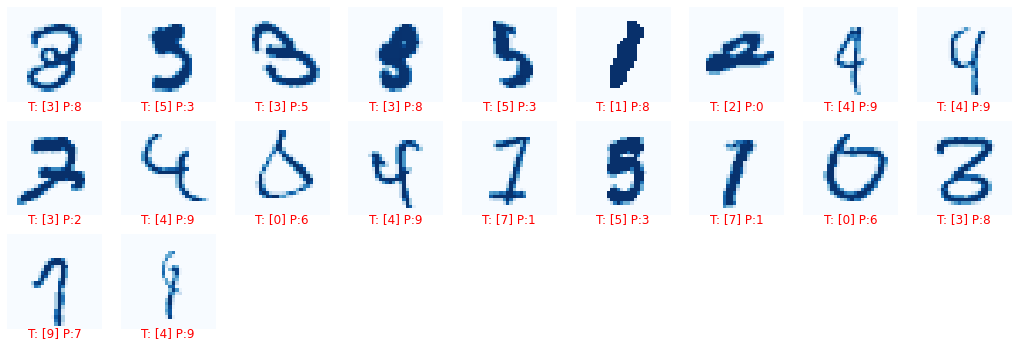

In [23]:
#Visualizing Result

rows = 4
cols = 9

f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1
for i in range(val_x.shape[0]):
    if val_y[i]!=val_p[i]:
        f.add_subplot(rows,cols,sub_plot) 
        sub_plot+=1
        plt.imshow(val_x[i].reshape([28,28]),cmap="Blues")
        plt.axis("off")
        plt.title("T: "+str(val_y[i])+" P:"+str(val_p[i]), y=-0.15,color="Red")
plt.show()

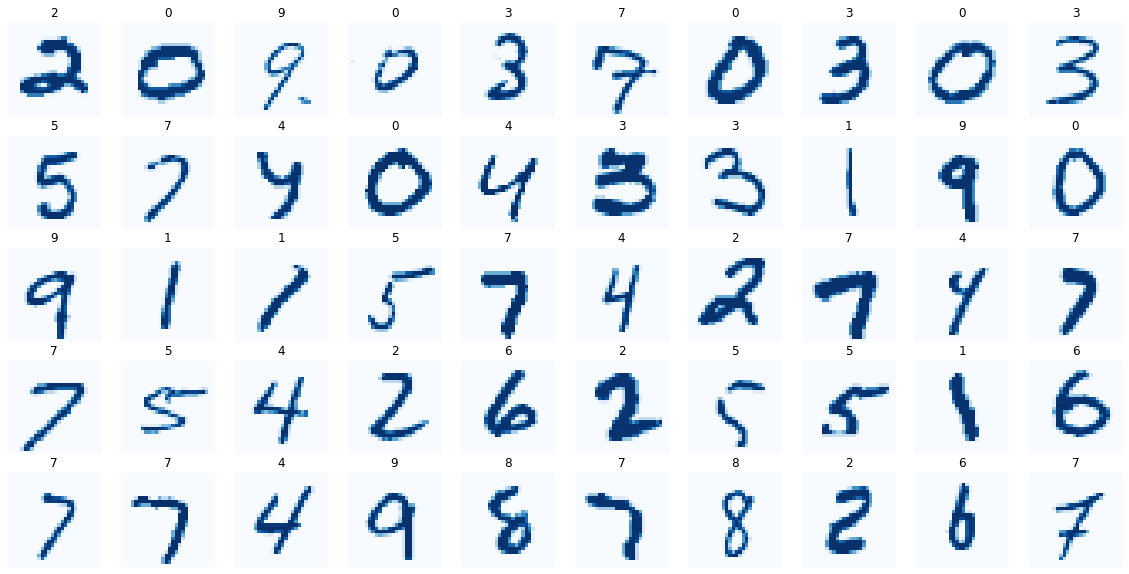

In [24]:
#Predict on test set¶


test_y = np.argmax(model.predict(test_x),axis =1)

rows = 5
cols = 10

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols):
    f.add_subplot(rows,cols,i+1)
    plt.imshow(test_x[i].reshape([28,28]),cmap="Blues")
    plt.axis("off")
    plt.title(str(test_y[i]))


In [25]:
df_submission = pd.DataFrame([test.index+1,test_y],["ImageId","Label"]).transpose()
df_submission.to_csv("submission.csv",index=False)